In [2]:
# PART A: PARTICLE TRACKING
from __future__ import division, unicode_literals, print_function # for compatibility with Python 2 and 3
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import os
from pandas import DataFrame, Series # for convenience
import pims
import trackpy as tp


# Optionally, tweak styles.
mpl.rc('figure', figsize=(10, 5))
mpl.rc('image', cmap='gray')

@pims.pipeline
def gray(image):
    return image[:, :, 1] # Take just the green channel

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


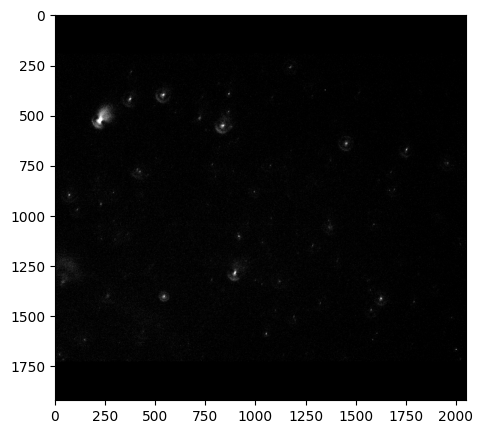

In [3]:
frames = gray(pims.Video('A2.avi'))
print(frames[0])
plt.imshow(frames[0])

            y            x         mass       size       ecc     signal  \
0  206.748910  1005.132229  3055.133301  20.664203  0.203182  15.981517   
1  209.009646  1254.769366  3037.376060  21.686029  0.372098  15.981517   
2  210.885364   758.600640  3330.370535  21.032569  0.266784  15.981517   
3  213.981566  1086.317073  3130.601575  22.292753  0.205504  11.542207   
4  216.468577   339.511175  3376.539361  23.268828  0.122662  15.093655   

   raw_mass   ep  frame  
0    4300.0  0.0      0  
1    4184.0  0.0      0  
2    4879.0  0.0      0  
3    4673.0  0.0      0  
4    5333.0  0.0      0  


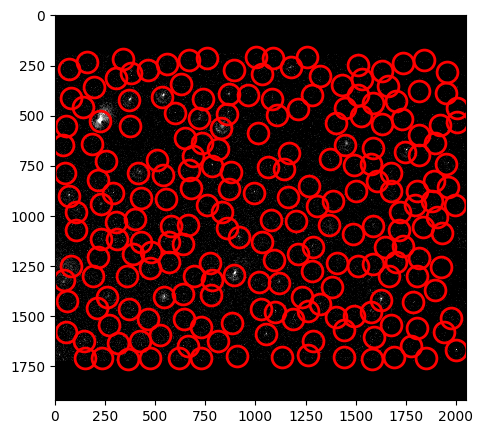

<Axes: >

In [4]:
# STEP 2: LOCATE FEATURES
f = tp.locate(frames[0], 69)
print(f.head()) # See top rows and columns for frame 0
plt.figure()
tp.annotate(f, frames[0])

The minimum value of mass is: 1668.292784703117


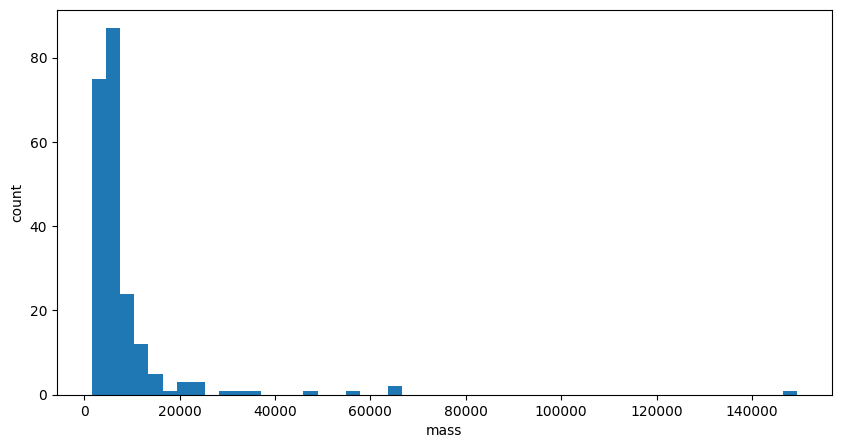

In [5]:
# Diagnostics
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)
ax.set(xlabel='mass', ylabel='count')

min_value = f['mass'].min()
print("The minimum value of mass is:", min_value)


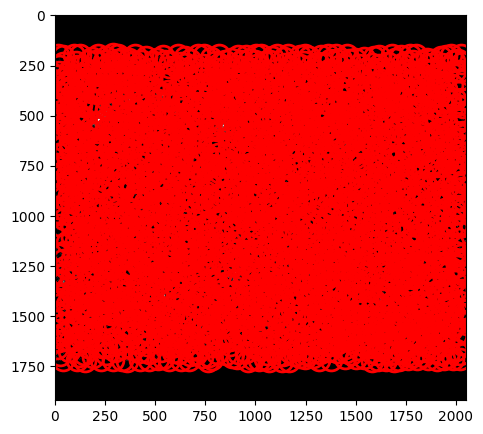

<Axes: >

In [6]:
f = tp.locate(frames[0], 21)
tp.annotate(f, frames[0])

/usr/local/lib/python3.11/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()
/usr/local/lib/python3.11/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

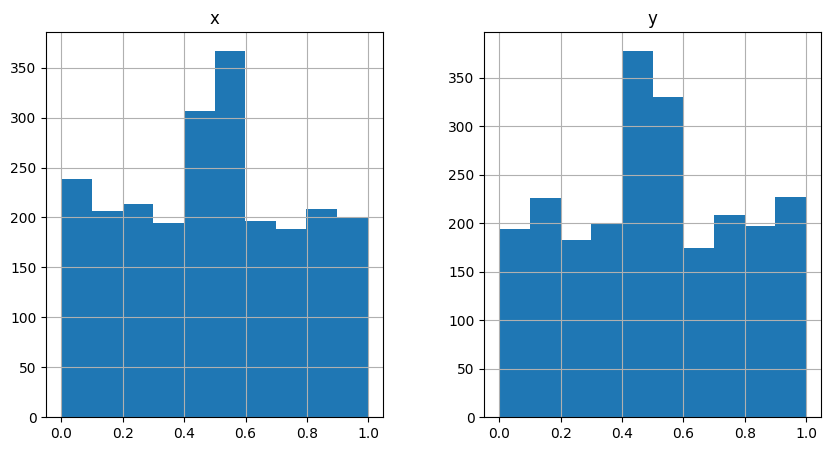

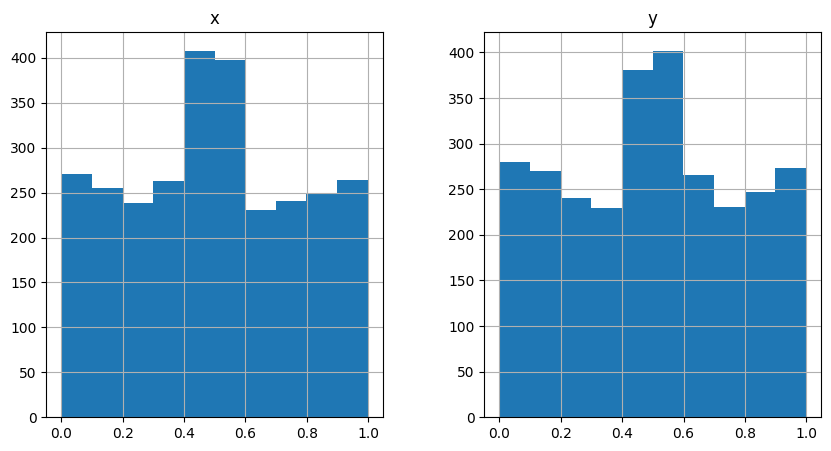

In [7]:
# Subpixel accuracy
tp.subpx_bias(f)
pixel_dia = 19
tp.subpx_bias(tp.locate(frames[0], pixel_dia))

In [8]:
f = tp.batch(frames[:100], pixel_dia, engine='numba',processes=1)

Frame 99: 2841 features


In [9]:
# STEP 3: LINK FEATURES INTO PARTICLE TRAJECTORIES
t = tp.link(f, 8, memory=4)

Frame 99: 2841 trajectories present.


Before: 114722
After: 1597


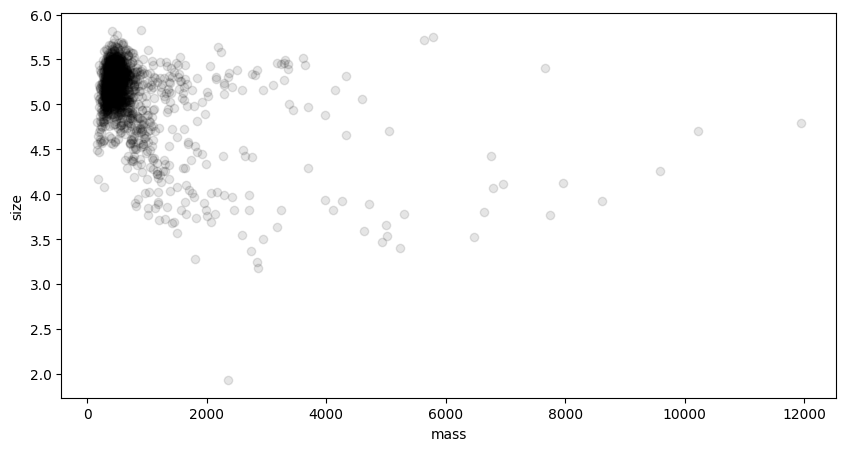

<Axes: xlabel='mass', ylabel='size'>

In [10]:
# Filter spurious trajectories
t1 = tp.filter_stubs(t, 10)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())
plt.figure()
tp.mass_size(t1.groupby('particle').mean()) # convenience function -- just plots size vs. mass

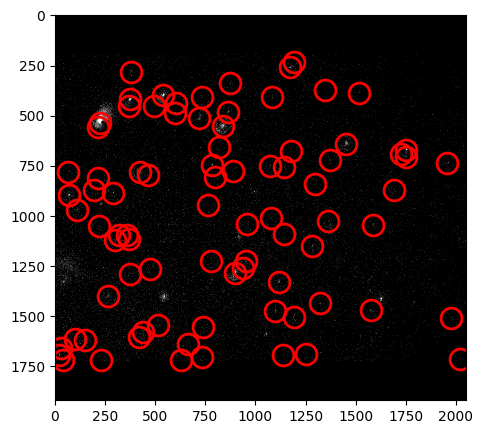

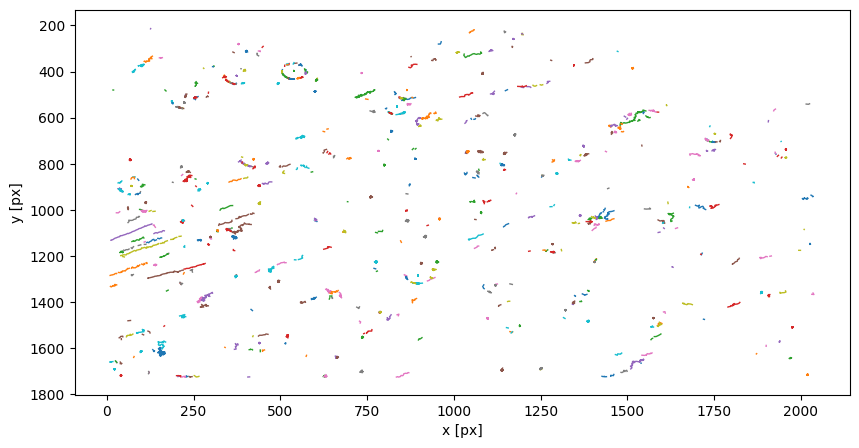

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [11]:
t2 = t1[((t1['mass'] > 650) & (t1['size'] < 8) & (t1['ecc'] < 0.5))]
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0])

plt.figure()
tp.plot_traj(t2)

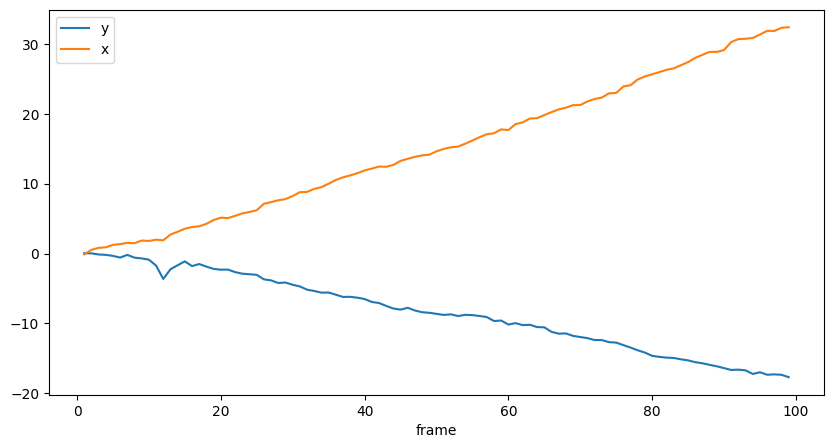

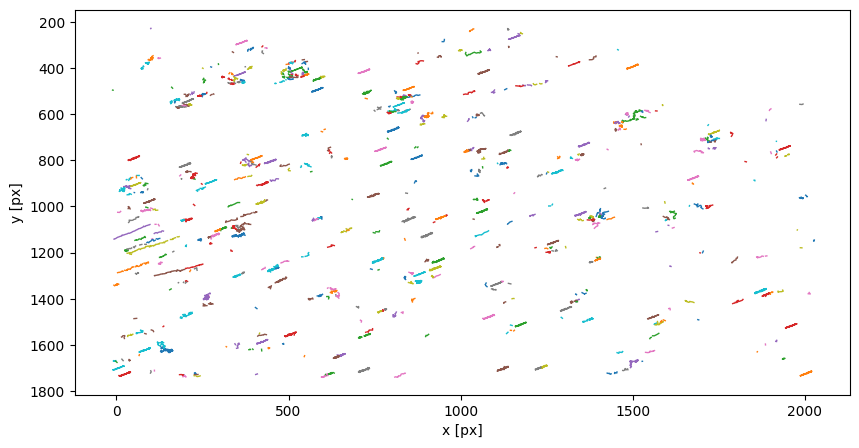

In [12]:
# Remove overall drift
d = tp.compute_drift(t2)
d.plot()
plt.show()

tm = tp.subtract_drift(t2.copy(), d)

ax = tp.plot_traj(tm)
plt.show()

In [13]:
# STEP 4: ANALYZE TRAJECTORIES
tm = tm.reset_index(drop=True)
mpp = 0.055 # microns per pixel
#im = tp.imsd(tm, mpp, 6.2) # microns per pixel = 0.055, frames per second = 6.2

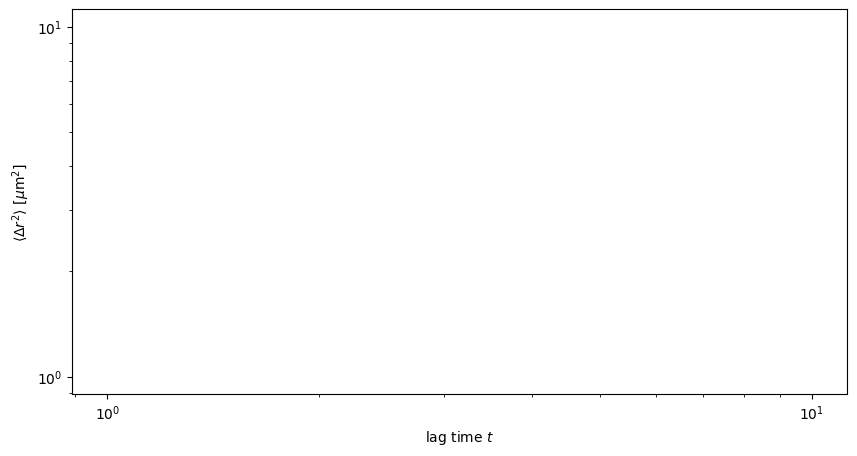

In [14]:
fig, ax = plt.subplots()
#ax.plot(im.index, im, 'k-', alpha=0.1) # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', 
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

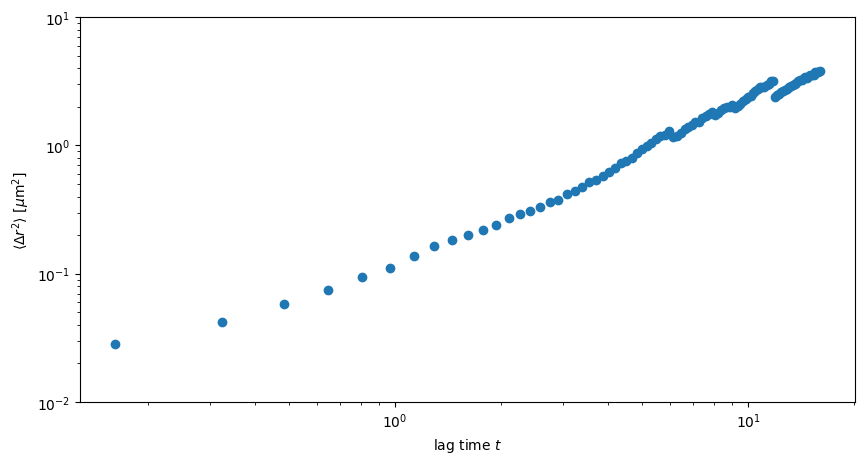

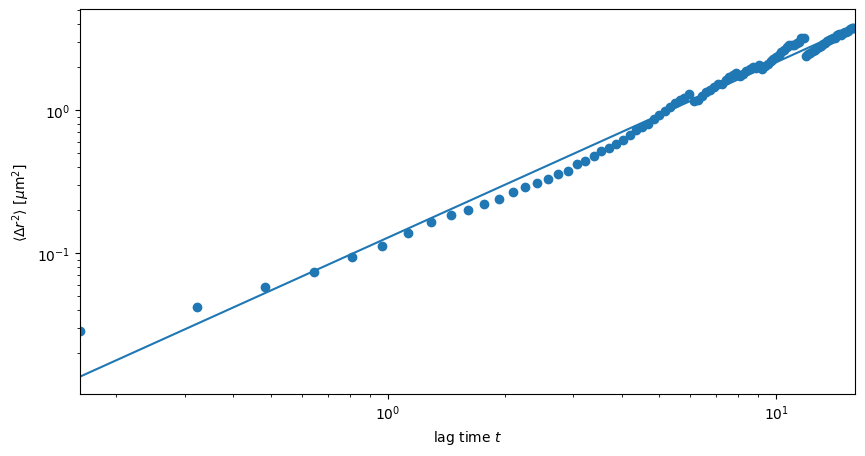

,n,A
msd,1.226488,0.128517


In [15]:
# Ensemble Mean Squared Displacement
em = tp.emsd(tm, mpp, 6.2) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10))

plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$')
tp.utils.fit_powerlaw(em) # performs linear best fit in log space, plots

In [16]:
# Find the optical radius
all_size_list_r = []  # To store radius lists for all frames
for frame in range(100):  # Loop through 100 frames to get better estimate
    size_list = t2["size"][frame].to_list() # Particle sizes current frame, use t2 for filter
    size_list_r = [elem / 2 * mpp for elem in size_list]  # Convert to radius in microns
    all_size_list_r.extend(size_list_r)  # Collect the radius list from all frames

# Save as CSV
df = pd.DataFrame(all_size_list_r)
df.to_csv('optical_radius_A2.csv', index=False)

# Now calculate the mean and standard deviation across all frames
r_optical = [f'{np.mean(all_size_list_r):.2e} \u00B1 {np.std(all_size_list_r):.2e}']

A_value = 0.128517 # Add all the decimals
D_value = A_value/4 #um^2/s
r_hyd = (293 * 1.38*10**-23) / (6 * np.pi * 10**-3 * D_value)

# Prepare the new values to replace
new_values = [f'{D_value:.2e}', f'{r_hyd:.2e}', r_optical]

# Check if the file exists and read existing rows
rows = {}
if os.path.exists('Lab_A_Data.csv'):
    with open('Lab_A_Data.csv', 'r', newline='') as f:
        reader = csv.reader(f)
        # Read the header row
        header = next(reader)
        # Store existing rows in a dictionary
        rows = {row[0]: row[1:] for row in reader}

# Replace the values in the specified row
rows['A2'] = new_values  # Replace or create the row

# Write all rows back to the CSV file
with open('Lab_A_Data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # Write the header row
    writer.writerow(['Row','Value D', 'r_hyd','r_optical'])
    # Write the data rows
    for row_name, values in rows.items():
        writer.writerow([row_name] + values)